In [1]:
import wikipediaapi
import requests
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Crawl a real-world dataset

## Data Source
In this project, given the non-profit nature of Wikipedia, which reduces the complexity of data acquisition, `WikiDataCrawl` class is created using `wikipediaapi` and `requests` to crawl data from wikipedia. For each page, I mainly focused on its `Title`, `Summary`, `Summary Length`, `Summary Word Count`,`Sections Length`, `Text Length`, `Word Count`, `Language Count` and `Pageviews`, The raw data obtained was transformed into `dictionary` and then transformed into `DataFrame` format. Finally it was saved it as a `CSV` file. 

In [2]:
class WikiDataCrawl:
    """
    A class for crawling data from wikipedia.

    Attributes:
        __user_agent: A string representing the user agent information.
        __titles: A list to store the title of the Wikipedia article.
        __wiki_data: A DataFrame to store the data crawling from Wikipedia
    """
    def __init__(self):
        """
        Initializes the instance.
        """
        self.__user_agent = "Wikipedia_Data_Analytics (nv22224@bristol.ac.uk)"
        self.__titles = []
        self.__wiki_data = pd.DataFrame(columns=['Title','Sumary', 'Sumary Length','Sumary Word Count','Sections Length',
                                                 'Text Length', 'Word Count',
                                                 'Language Count', 'Pageviews'])
        
    def get_random_wikipedia_titles(self, title_nums=200):
        """
        Randomly get Wikipedia articles' titles.
        
        Args:
          title_nums: An integer representing the number of the titles to crawl

        Returns:
          A list storing the titles crawled from Wikipedia.
        """
        api_url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&list=random&rnnamespace=0&rnlimit={title_nums}"
        response = requests.get(api_url)
        data = response.json()

        # Obtain the title list
        self.__titles = [page['title'] for page in data['query']['random']]

        return self.__titles 
        
    def get_wikipedia_page_info(self, title: str):
        """
        Randomly get Wikipedia articles' titles.

        Args:
          title: A string representing the title of the Wikipedia article

        Returns:
          A dictionary storing the page's information.
        """
        # Create a Wikipedia API object
        wiki_wiki = wikipediaapi.Wikipedia(self.__user_agent, 'en')

        # Obtain a page object
        page = wiki_wiki.page(title)

        if not page.exists():
            return None

        # Obtain the length and word count of the page
        page_length = len(page.text)
        page_word_count = len(page.text.split())

        # Construct an API URL to retrieve Wikipedia page information
        api_url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&titles={title}&prop=info|pageviews"
        response = requests.get(api_url)
        data = response.json()

        # Obtain the language count of the page 
        langlinks = page.langlinks
        language_count = len(langlinks)

        try:
            # Obtain the page views
            page_info = data["query"]["pages"]
            page_id = list(page_info.keys())[0]
            pageviews = page_info[page_id]["pageviews"]
            
        except KeyError:
            return None


        # Create a dictionary for storing page information.
        page_data = {
            "Title": page.title, # The title of the page 
            "Sumary": page.summary[:100], # The summary of the page
            "Sumary Length": len(page.summary), # The number of the characters of the page summary.
            "Sumary Word Count": len(page.summary.split()), # The number of the words of the page summary.
            "Sections Length": len(page.sections), # The number of the sections of the page.
            "Text Length": page_length, # The number of the characters of the page.
            "Word Count": page_word_count, # The number of the words of the page.
            "Language Count": language_count + 1, # The number of the languages that page has
            "Pageviews": pageviews # The daily pageviews of the page from 2023-10-26 to 2023-12-24.
        }
        return page_data
    
    def __call__(self, title_nums):
        """
        Randomly obtain Wikipedia page information.

        Args:
          title_nums: An integer representing the number of the titles to crawl

        Returns:
          A DataFrame storing the pages' information.
        """
        title_list = self.get_random_wikipedia_titles(title_nums) 
        
        for title in title_list:
            page_data = self.get_wikipedia_page_info(title)
            if page_data is not None:
                self.__wiki_data.loc[len(self.__wiki_data)] = page_data
        
        return self.__wiki_data

## Crawl data

The expected number of the pages that I wanted to crawl is `600`, however, only `499` articles was crawled because some pages only had titles but didn't exist. The data was saved in `csv` format.

In [3]:
# Please uncomment the following code if you wan to crawl data
# wiki_data_crawl = WikiDataCrawl()
# wiki_data = wiki_data_crawl(600) # Set the number of the pages to be crawled
# wiki_data.to_csv('wiki_data.csv', index=False) # Save the data in 'csv' format

# Step 2: Perform data preparation & cleaning

## Load Data 

In [4]:
wiki_data = pd.read_csv("wiki_data.csv") # Load the data from local storage.
wiki_data.rename(columns={"Sumary": "Summary", "Sumary Length": "Summary Length",
                          "Sumary Word Count": "Summary Word Count"}, inplace=True) # correct the spelling errors

## Data Cleaning

This section is to handle missing data or outliers if any.

In [5]:
display(wiki_data.head(10))
print("===========================================================================================================")
print(f"wiki_data's shape is {wiki_data.shape}")
print("===========================================================================================================")
display(wiki_data.info())

,Title,Summary,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Pageviews
0,Frederick August Baumbach,Frederick August Baumbach (1753 – 30 November ...,1725,267,0,1725,267,4,"{'2023-10-26': None, '2023-10-27': 1, '2023-10..."
1,The Rat Trap,The Rat Trap (1918) is a four-act drama by Noë...,397,73,8,4439,749,1,"{'2023-10-26': 4, '2023-10-27': 6, '2023-10-28..."
2,Find Another Way,"""Find Another Way"" is a song by German musicia...",246,42,6,1332,224,3,"{'2023-10-26': 3, '2023-10-27': 1, '2023-10-28..."
3,Pteriomorphia,The Pteriomorphia comprise a subclass of saltw...,719,105,4,3869,518,28,"{'2023-10-26': 22, '2023-10-27': 35, '2023-10-..."
4,Danielle Bunten Berry,"Danielle Bunten Berry (February 19, 1949 – Jul...",548,96,11,11283,1913,11,"{'2023-10-26': 58, '2023-10-27': 43, '2023-10-..."
5,City Lights,City Lights is a 1931 American silent romantic...,1805,292,8,27890,4750,53,"{'2023-10-26': 428, '2023-10-27': 506, '2023-1..."
6,Eliza A. Dupuy,"Eliza Ann Dupuy (c. 1814 – December 29, 1880) ...",895,149,5,6433,1037,1,"{'2023-10-26': 0, '2023-10-27': 1, '2023-10-28..."
7,El-Gendi Fortress,The El-Gendi Fortress (Arabic: قلعة الجندي) is...,458,67,3,680,100,6,"{'2023-10-26': 3, '2023-10-27': 20, '2023-10-2..."
8,Bądzsław,Bądzsław [ˈbɔ̃tswaf] is a masculine Old Polish...,196,34,0,196,34,2,"{'2023-10-26': None, '2023-10-27': 0, '2023-10..."
9,Acceptance discography,"The discography of Acceptance, an American alt...",135,20,2,199,29,1,"{'2023-10-26': 4, '2023-10-27': 2, '2023-10-28..."


wiki_data's shape is (499, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               499 non-null    object
 1   Summary             499 non-null    object
 2   Summary Length      499 non-null    int64 
 3   Summary Word Count  499 non-null    int64 
 4   Sections Length     499 non-null    int64 
 5   Text Length         499 non-null    int64 
 6   Word Count          499 non-null    int64 
 7   Language Count      499 non-null    int64 
 8   Pageviews           499 non-null    object
dtypes: int64(6), object(3)
memory usage: 35.2+ KB


None

## Create new features

In this section, new features `Average Pageviews`, `Max Pageviews`, `Summary Content Ratio(%)` and `Only Summary` are created for to enrich the data, where `Average Pageviews` represents the average page views from `2023-10-26` to `2023-12-24`, `Max Pageviews` represents the max page views from `2023-10-26` to `2023-12-24`, `Summary Content Ratio(%)` represents the ratio of the number of words in the `Summary` to the total number of words in the full text of the page and `Only Summary` indicates that whether the page only consists of `Summary` Section.

In [6]:
wiki_data["Pageviews"] = wiki_data["Pageviews"].apply(lambda x: eval(x))

In [7]:
def dict_average(dictionary: dict):
    """
    Calculate the average value of the dictionary's value.

    Args:
      dictionary: The dictionary for calculation

    Returns:
      A numerical value representing the the average value of the dictionary's value.
    """
    # Check if dictionary is null
    if dictionary is None:
        return None  

    # Filter null value
    valid_values = [value for value in dictionary.values() if value is not None]
    
    # Check if all values are null
    if valid_values is None:
        return None  

    # Calculate the average
    average = round((sum(valid_values) / len(valid_values)))
    return average

def dict_max(dictionary: dict):
    """
    Obtain the average value of the dictionary's value.

    Args:
      dictionary: The dictionary for calculation

    Returns:
      A numerical value representing the the max value of the dictionary's value.
    """
    value_set = set()
    
    for value in dictionary.values():
        if value is not None:
            value_set.add(value)
            
    if value_set is not None:
        return max(value_set)
    else:
        return None

wiki_data["Average Pageviews"] = wiki_data["Pageviews"].apply(dict_average)
wiki_data["Max Pageviews"] = wiki_data["Pageviews"].apply(dict_max)

In [8]:
wiki_data.drop(columns=["Pageviews"],axis=1,inplace=True)
wiki_data["Summary Content Ratio(%)"] = round(wiki_data["Summary Word Count"]/wiki_data["Word Count"] * 100, 2)

In [9]:
wiki_data["Only Summary"] = wiki_data["Summary Content Ratio(%)"].apply(lambda x: 1 if x==100.00 else 0) # If the page only has summary

In [10]:
wiki_data.head()

,Title,Summary,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Average Pageviews,Max Pageviews,Summary Content Ratio(%),Only Summary
0,Frederick August Baumbach,Frederick August Baumbach (1753 – 30 November ...,1725,267,0,1725,267,4,1,4,100.00,1
1,The Rat Trap,The Rat Trap (1918) is a four-act drama by Noë...,397,73,8,4439,749,1,7,19,9.75,0
2,Find Another Way,"""Find Another Way"" is a song by German musicia...",246,42,6,1332,224,3,3,11,18.75,0
3,Pteriomorphia,The Pteriomorphia comprise a subclass of saltw...,719,105,4,3869,518,28,172,4317,20.27,0
4,Danielle Bunten Berry,"Danielle Bunten Berry (February 19, 1949 – Jul...",548,96,11,11283,1913,11,45,96,5.02,0


## Step 3: Perform exploratory data analysis (EDA)

In this section, I performed EDA on numerical features of this dataset. However, `Only Summary` is not counted as a numerical feature as the calculation of statistics such as average is meaningless for this bianary feature.

In [11]:
numerical_columns = ['Summary Length', 'Summary Word Count',
       'Sections Length', 'Text Length', 'Word Count', 'Language Count',
       'Average Pageviews', 'Max Pageviews', 'Summary Content Ratio(%)']
wiki_data_numerical = wiki_data.loc[:,numerical_columns]

In [12]:
wiki_data_numerical_statistics = wiki_data_numerical.describe().T
sum_column = pd.Series(wiki_data_numerical.sum(), name="sum")
wiki_data_numerical_statistics = pd.concat([wiki_data_numerical_statistics, sum_column], axis=1)
wiki_data_numerical_statistics["count"] = wiki_data_numerical_statistics["count"].astype(int)
wiki_data_numerical_statistics["mean"] = wiki_data_numerical_statistics["mean"].apply(lambda x: round(x, 2))
wiki_data_numerical_statistics["std"] = wiki_data_numerical_statistics["std"].apply(lambda x: round(x, 2))
display(wiki_data_numerical_statistics)

,count,mean,std,min,25%,50%,75%,max,sum
Summary Length,499,479.29,509.44,17.00,175.50,311.00,548.50,4251.0,239165.00
Summary Word Count,499,76.66,79.72,4.00,28.00,50.00,88.00,684.0,38253.00
Sections Length,499,3.59,3.24,0.00,1.00,3.00,5.00,28.0,1791.00
Text Length,499,3198.59,5501.65,70.00,444.50,1190.00,3378.50,46962.0,1596094.00
Word Count,499,507.35,858.47,11.00,70.50,195.00,522.00,6988.0,253168.00
Language Count,499,5.98,9.45,1.00,1.00,3.00,7.00,130.0,2985.00
Average Pageviews,499,43.31,319.97,0.00,1.00,2.00,9.00,6360.0,21612.00
Max Pageviews,499,128.68,766.06,0.00,3.00,9.00,26.50,13252.0,64210.00
Summary Content Ratio(%),499,44.94,37.44,0.29,9.43,30.64,87.94,100.0,22427.04


In [13]:
wiki_data_numerical.sample(20)

,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Average Pageviews,Max Pageviews,Summary Content Ratio(%)
201,150,26,0,150,26,7,0,1,100.00
288,137,25,7,3390,572,5,0,2,4.37
54,364,63,10,13150,2190,11,64,234,2.88
294,106,16,0,106,16,1,0,2,100.00
180,343,47,1,445,62,10,13,26,75.81
452,307,51,5,7655,1098,1,3,12,4.64
35,288,39,0,288,39,1,1,3,100.00
219,1542,271,2,1727,297,1,0,4,91.25
279,870,157,2,942,168,3,2,8,93.45
358,136,22,2,321,52,1,0,1,42.31


The following graph of histplots shows the distribution of the numerical features `Summary Length`, `Summary Word Count`, `Sections Length`, `Text Length`, `Word Count`, `Language Count`, `Average Pageviews`, `Max Pageviews` and `Summary Content Ratio(%)`.

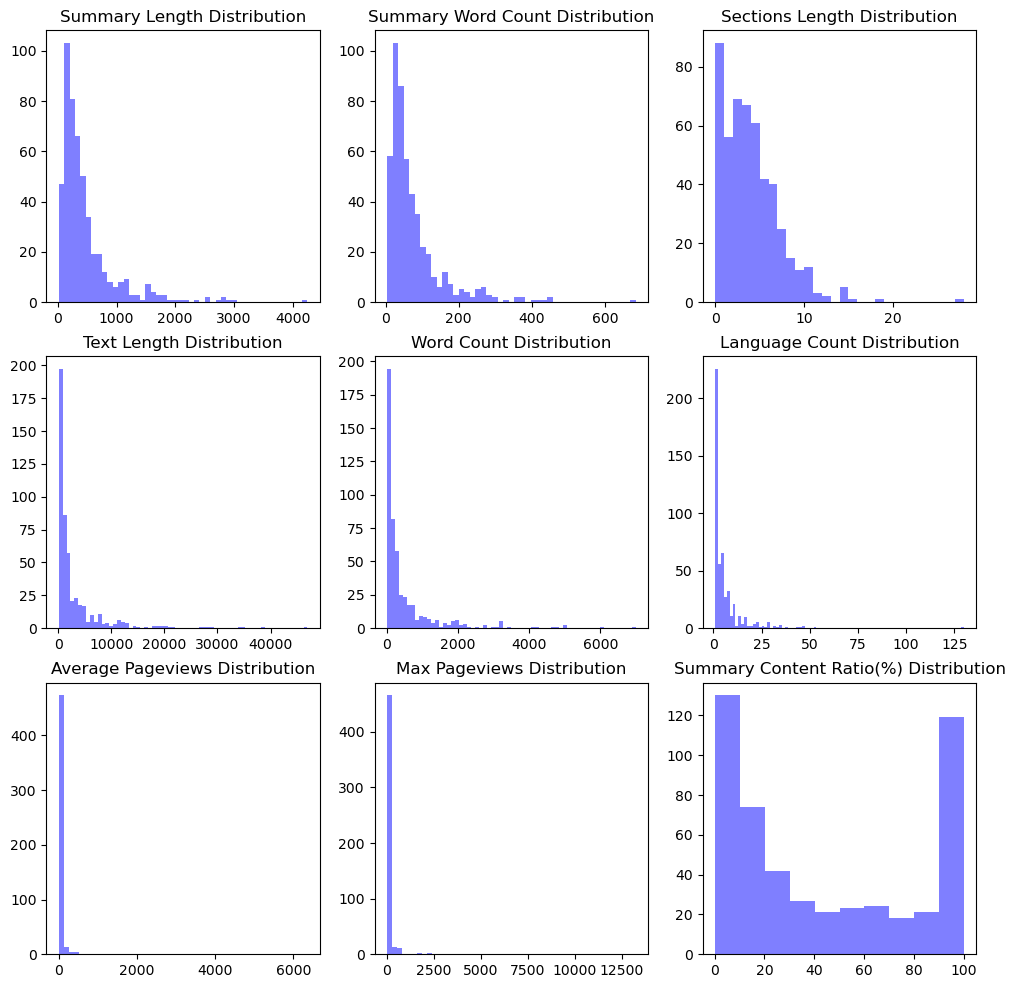

In [14]:
index = 0
wiki_data_numerical_columns = list(wiki_data_numerical.columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for i in range(3):
    for j in range(3):
        title = wiki_data_numerical_columns[index]
        
        data = wiki_data_numerical[title]
        
        if "Pageviews" not in title:
            axes[i, j].hist(x=data, bins='auto', color='blue', alpha=0.5)
        else:
            axes[i, j].hist(x=data, bins=50, color='blue', alpha=0.5)
        axes[i, j].set_title(f"{title} Distribution")
        index += 1

The scatter plot below shows the relationship between `Summary Word Count` and `Summary Length`. The graph below shows that there is linear relationship between the two features.

Text(0, 0.5, 'Summary Length')

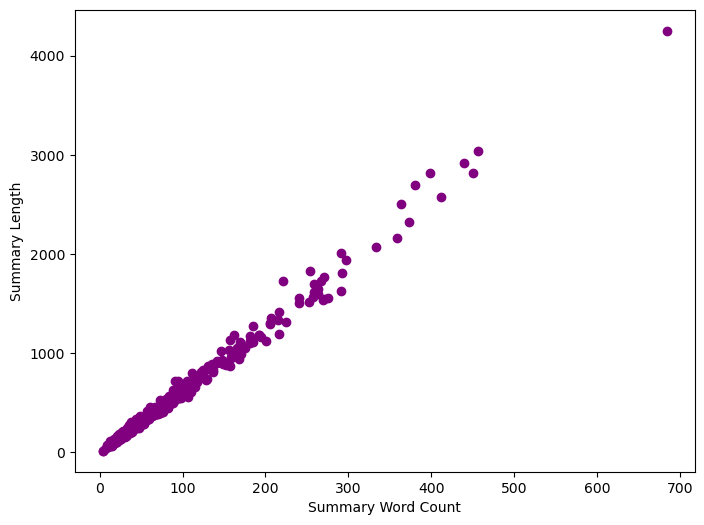

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Summary Word Count"]
y = wiki_data_numerical["Summary Length"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Summary Word Count")
ax.set_ylabel("Summary Length")

The scatter plot below shows the relationship between `Max Pageviews` and `Language Count`.

Text(0, 0.5, 'Language Count')

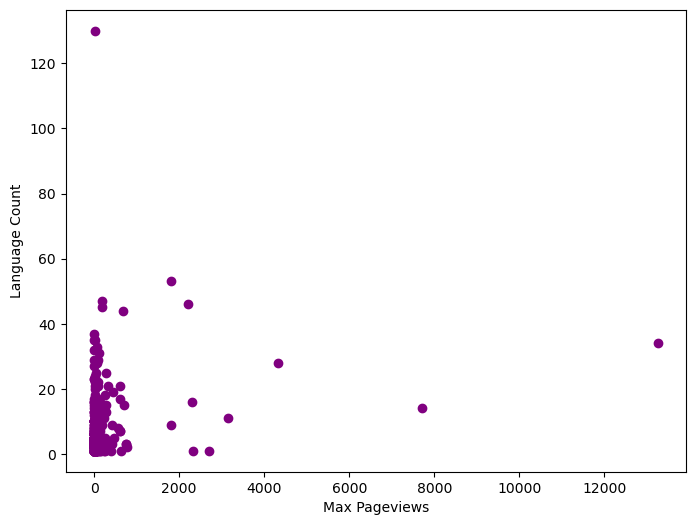

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Max Pageviews"]
y = wiki_data_numerical["Language Count"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Max Pageviews")
ax.set_ylabel("Language Count")

The scatter plot below shows the relationship between `Average Pageviews` and `Max Pageviews`.

Text(0, 0.5, 'Max Pageviews')

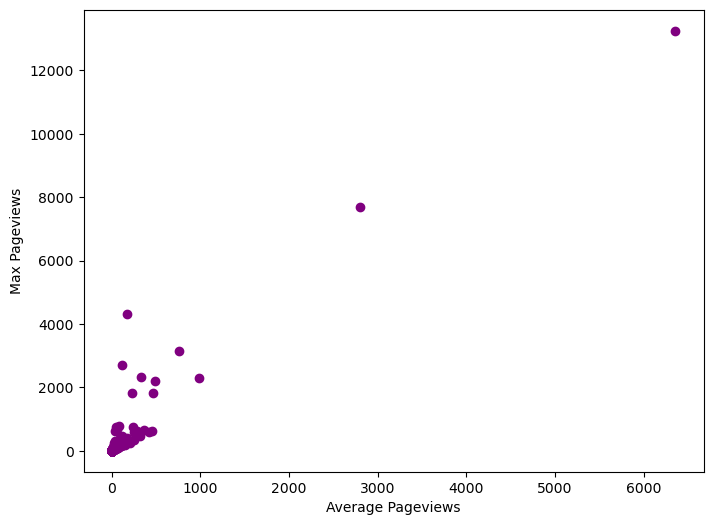

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Average Pageviews"]
y = wiki_data_numerical["Max Pageviews"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Average Pageviews")
ax.set_ylabel("Max Pageviews")

The scatter plot below shows the relationship between `Word Count` and `Sections Length`.

Text(0, 0.5, 'Sections Length')

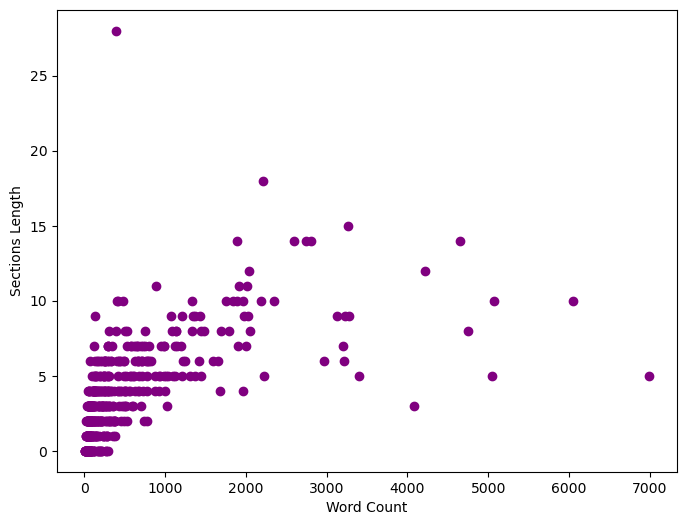

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Word Count"]
y = wiki_data_numerical["Sections Length"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Word Count")
ax.set_ylabel("Sections Length")

The boxplots below show the distribution of numerical features excepted `Sections Length` and `Summary Content Ratio(%)` grouped by `Only Summary` feature.

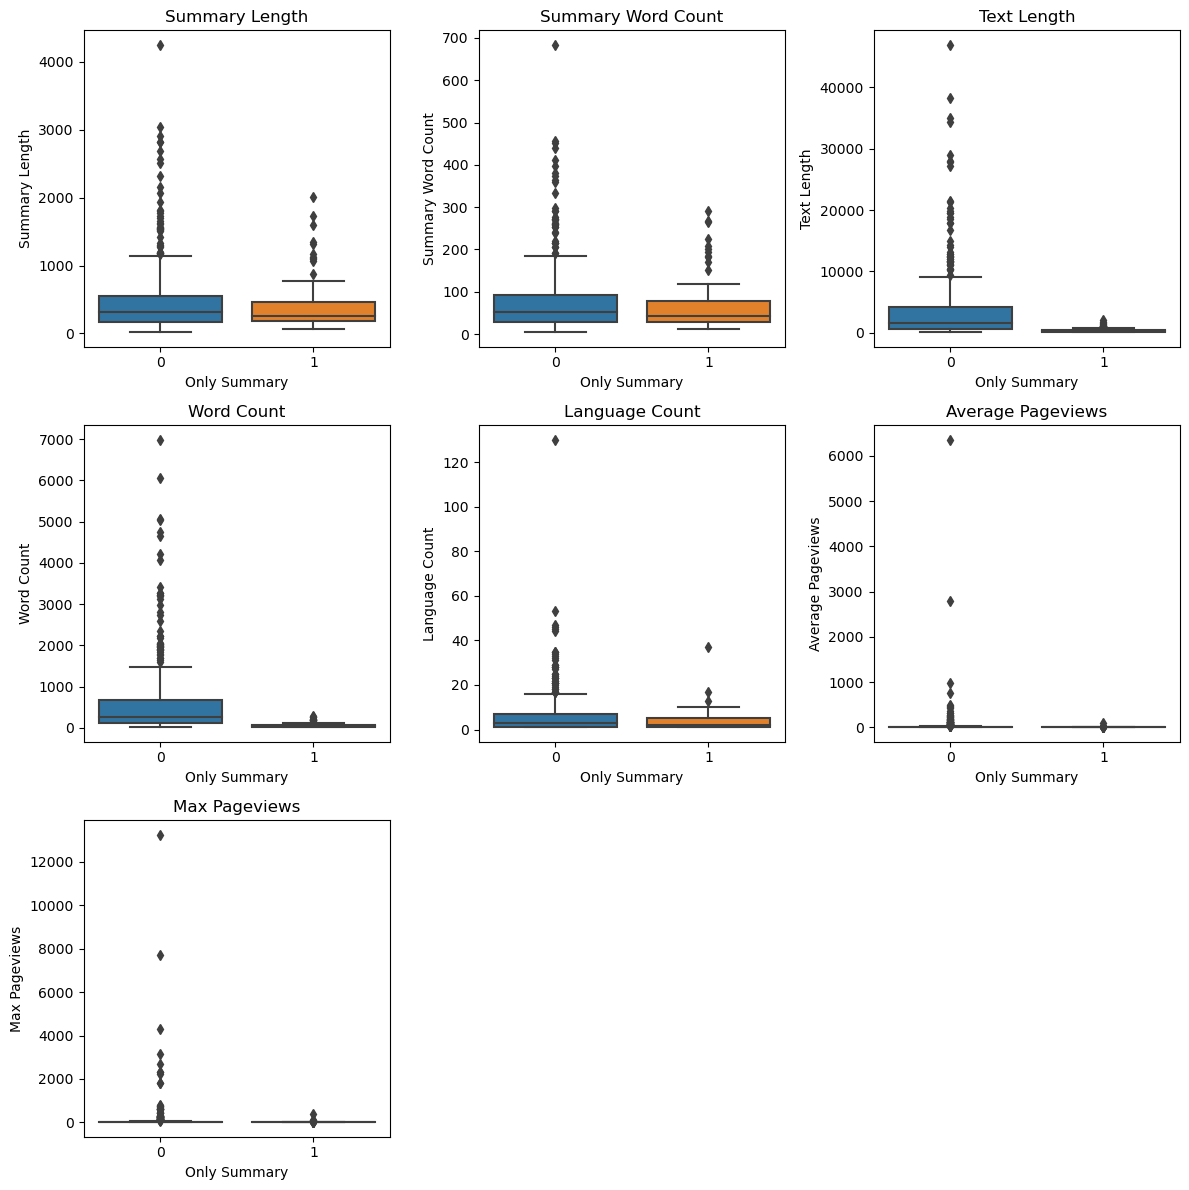

In [19]:
columns = [col for col in wiki_data_numerical.columns if col not in ["Sections Length", "Summary Content Ratio(%)"]]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, (title, ax) in enumerate(zip(columns, axes.flatten())):
    sns.boxplot(x="Only Summary" , y=title, data=wiki_data, ax=ax)
    ax.set_title(title)
    
axes.flatten()[7].set_visible(False)
axes.flatten()[8].set_visible(False)
    
plt.tight_layout()

The boxplots below show the distribution of `Average Pageviews` and `Max Pageviews` grouped by `Only Summary` feature.

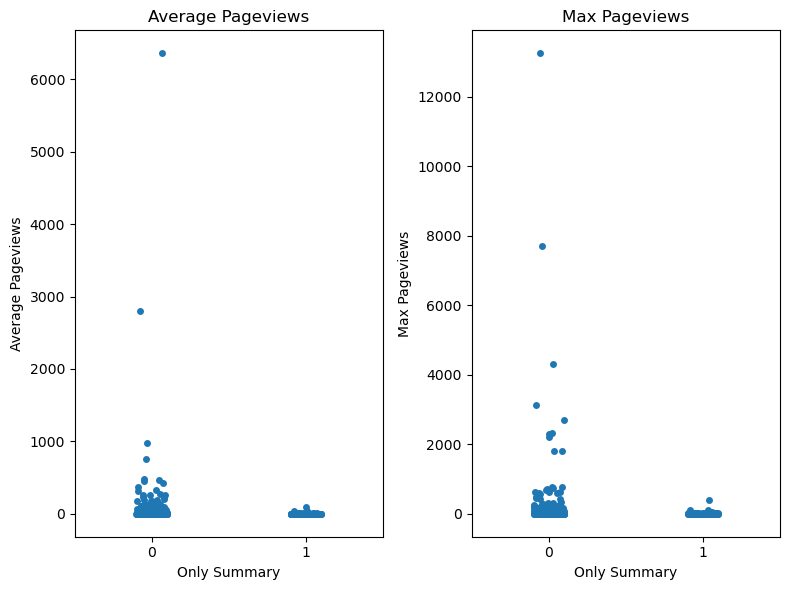

In [20]:
columns = ['Average Pageviews', 'Max Pageviews']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))

for i, (title, ax) in enumerate(zip(columns, axes.flatten())):
    sns.stripplot(x="Only Summary" , y=title, data=wiki_data, ax=ax)
    ax.set_title(title)
    
plt.tight_layout()
plt.show()

# Step 4: Ask questions

## Question a: Is `Sections Length` normally distributed? 

### Shapiro–Wilk test

The Shapiro–Wilk goodness-of-fit test is used to determine if a random sample, $X_i, i=1, 2, ..., n,$ is drawn from a normal Gaussian probability distribution, and the hypothesis is: 
<div style="text-align:center">
$H_0:$ The random sample was drawn from a normal population<br>   
$H_1:$ The random sample was not normal distributed.
</div>

This project will use Shapiro–Wilk test statistic, which is given by:  
$$ W = \frac{\left(\sum_{i=1}^{n} a_i x_{(i)}\right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2} $$
where $x_{(i)}$ is the sorted sample value, $\bar{x}$ is the sample mean, and $a_i$ is given by the following formulas:  
$$(a_1, a_2, ..., a_n) =  \frac{m^{T}V^{-1}}{({m^{T}V^{-1}m})^\frac{1}{2}}$$  
where ${(m_1, m_2, ...,m_n)^{T}}$ is the expected values of the ordered statistics that are independent and identically distributed random variables that follow the standard normal, and $V$ is the covariance matrix of the order statistics ([Ramachandran & Tsokos, 2020](#Ramachandran-2020)).

In this project, $\alpha = 0.05$, and we will use `scipy.stats.shapiro` package to calculate $W$ and `p` value.

In [21]:
from scipy.stats import shapiro

In [22]:
W, p_value = shapiro(wiki_data_numerical["Sections Length"])

print(f"Shapiro-Wilk Statistic is {W:.2f}")
print(f"P-value is {p_value:.2f}")

Shapiro-Wilk Statistic is 0.87
P-value is 0.00


According to the result, we should reject $H_0$  as $p < \alpha$, therefore, `Sections Length` is not normally distributed.

## Question b: Is there a linear relationship between `Word Count` and `Text Length`? 

In [23]:
from scipy.stats import pearsonr

In [24]:
x = wiki_data_numerical.loc[:,"Word Count"].to_numpy()
y = wiki_data_numerical.loc[:,"Text Length"].to_numpy()

The Pearson correlation method is the most common method to use for numerical variables; it assigns a value between `−1` and `1`, where `0` is no correlation, `1` is total positive correlation, and `−1` is total negative correlation ([Williams et al., 2020](#Williams-2020)).

### Hypothesis Testing:

1. Supposed that $\rho$ represents the population correlation coefficient, The null hypothesis $H_0$ and alternative hypothesis $H_1$ for this test are as follows:
$$H_0: \rho = 0 \\$$
$$H_1: \rho \neq 0$$

2. This test is based on the sample data's calculated correlation coefficient, using the t-statistic to assess whether the sample correlation coefficient is significantly different from zero. The formula for the t-statistic is:
$$t = \frac{r\sqrt[2]{n-2}}{1-r^2} \sim t(n-2)$$
where $r$ reprensts the the sample correlation coefficient and $n$ is the sample size.

3. Set $\alpha = 0.05$ and caculate the `p` value.

In [25]:
pc = pearsonr(x,y)[0]
print(f"Pearson correlation coefficient is {pc}.")

Pearson correlation coefficient is 0.9982001382921664.


In [26]:
p_value = pearsonr(x,y)[1]
print(f"p_value is {p_value:.2f}")

p_value is 0.00


 $p < \alpha$, therefore, $H_0$ should be rejected and that means there is a linear relationship between `Word Count` and `Text Length`.

## Question c: How to predict whether a Wikipedia article only has summary section based on features `Word Count`, `Language Count` and `Average Pageviews`? 

In [27]:
from sklearn.model_selection import train_test_split

According to the bar plot below, the `y` dataset is imbalance.

Only Summary
0    411
1     88
Name: count, dtype: int64

Text(0, 0.5, 'Count')

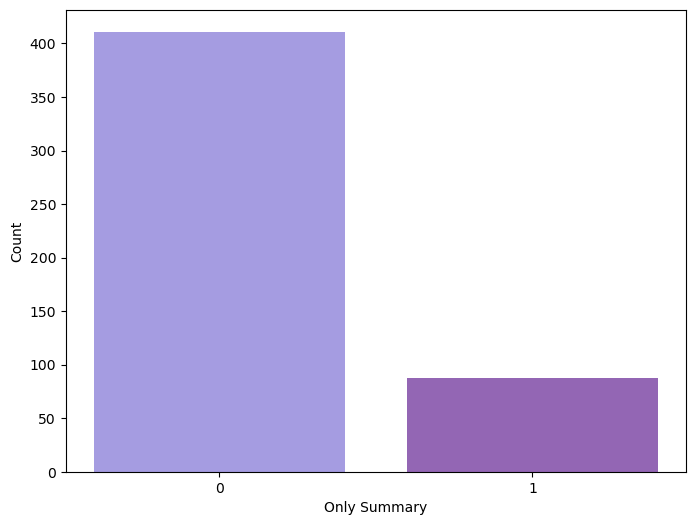

In [28]:
X = wiki_data.loc[:,["Word Count","Language Count","Average Pageviews"]]
y = wiki_data.loc[:,"Only Summary"]
fig, ax = plt.subplots(figsize=(8, 6))
print("=========================")
display(y.value_counts())
print("=========================")

y_labels = [str(i) for i in y.value_counts().index]
y_values = [i for i in y.value_counts().values]
ax.bar(y_labels,y_values,color=["slateblue","indigo"],alpha=0.6)
ax.set_xlabel("Only Summary")
ax.set_ylabel("Count")

### Stratified Sampling

According to the graph above, this dataset is imbalanced, if we use this dataset for training, the model would incorrectly classifies a positive instance as negative, therefore, the oversampling method should be applied to this dataset before training.

#### a. Split the dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### b. Oversampling the train dataset

In [30]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna

In [31]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

According to the barplot below, after applying the oversampling method, the imbalance issues have been effectively handled.

Only Summary
0    329
1    329
Name: count, dtype: int64

Text(0, 0.5, 'Count')

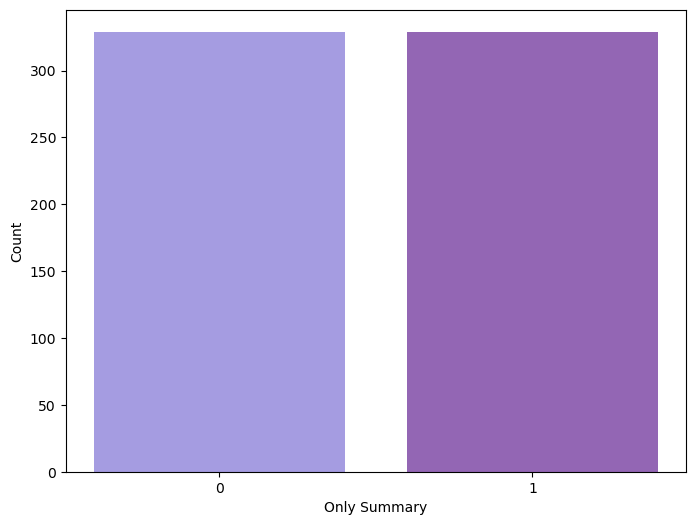

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

print("=========================")
display(y_resampled.value_counts())
print("=========================")

y_labels = [str(i) for i in y_resampled.value_counts().index]
y_values = [i for i in y_resampled.value_counts().values]
ax.bar(y_labels,y_values,color=["slateblue","indigo"],alpha=0.6)
ax.set_xlabel("Only Summary")
ax.set_ylabel("Count")

### Model trainning

`Random forests` are a machine learning algorithm for classification based on the averaging across multiple regression trees, each of which is trained on a subset of the data and with a subset of the explanatory variables.In this section, `Random Forest` is ultilised for building the classification model.

#### a.  Adjust the hyperparameters

`Optuna` is a hyperparameter optimization framework proposed by Takuya Akiba and colleagues([Akiba et al., 2019](#Takuya-2019)). In this section, `optuna` is used for adjusting the hyperparameters of the models automatically. Additionally `K-Fold validation` is used to reduce error and improve the robustness of the model. In this project, the average accuracy of the `K-Fold validation` is used as the metric in `objective` function.

In [33]:
def objective(trial):
    # define the searing range of each parameter
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'random_state': 42
    }
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies = []
    # K-fold validation
    for train_index, val_index in kf.split(X_resampled, y_resampled):
        X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
        y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

        model = RandomForestClassifier(**rf_params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

    return sum(accuracies) / len(accuracies)

#### b. Apply the best parameters to RandomForestClassifier

In [34]:
# Please uncomment the following code if you want to train the model
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# trial = study.best_trial
# rf_classifier = RandomForestClassifier(**trial.params)
# rf_classifier.fit(X_resampled, y_resampled)

#### c.  Save the model

In [35]:
import pickle

In [36]:
# Please uncomment the following code if you want to save the model you train
# with open("rf_classifier.pkl", "wb") as f:
#     pickle.dump(rf_classifier, f)

### Model Testing

#### a. Load model

In [37]:
with open("rf_classifier.pkl", "rb") as f:
    rf_classifier = pickle.load(f)

#### b. Obtain the predicting values

In [38]:
y_pred = rf_classifier.predict(X_test)

#### c. Evaluation

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In this section, I use five metrics for evaluation, which are `Accuracy`, `Recall`, `Precision`, `F1-Score` and `Confusion Matrix`. And `Accuracy`, `Recall`, `Precision` and `F1-Score` are calculated as the following formulas:
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$  
$$Recall = \frac{TP}{TP + FN}$$  
$$Precision = \frac{TP}{TP + FP}$$  
$$F1 = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$  
where `TP` (True Positive) is the number of samples that were correctly predicted as positive by the model, `TN` (True Negative) is the number of samples that were correctly predicted as negative by the model, `FP` (False Positive) is the number of samples that were incorrectly predicted as positive by the model when they are actually negative and `FN` (False Negative) is the number of samples that were incorrectly predicted as negative by the model when they are actually positive.

Accuracy is 0.87
F1 score is 0.72
Recall score is 0.94
Precision score is 0.59


Text(0.5, 1.0, 'Confusion Matrix')

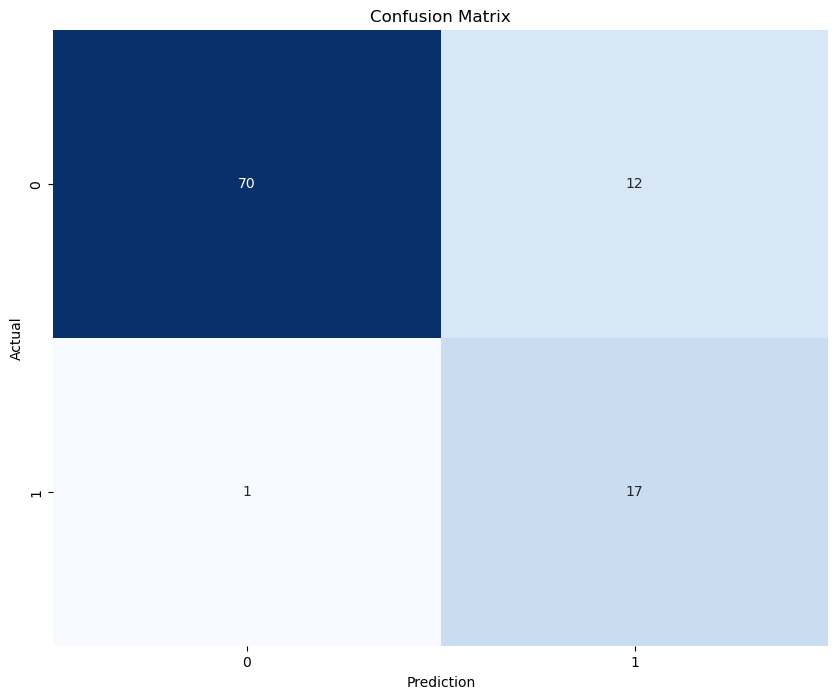

In [40]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy is {accuracy:.2f}")
print(f"F1 score is {f1:.2f}")
print(f"Recall score is {recall:.2f}")
print(f"Precision score is {precision:.2f}")

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

According to the results, the `accuarcy` and `recall` are high, while `precision` and `F1 score` are low. The `Confusion Matrix` shows that the model wrongly classifies the nagative samples as positive samples, which leads to reduction in `precision` and `F1 score`.

# Step 5: Summarise and write a conclusion

In this project, I found data acquisition on many platforms is a little difficult due to the business interest. Considered that the non-profit nature of Wikipedia, I finally decided to crawl data from Wikipedia. Having obtained the data, I performed data cleaning and EDA. After that three questions on this dataset were raised. In `Question 3`, I build a classification model using `Random Forest` algorithm. According to the result, the model `precision` is not satisifying. Moreover, the volume of the dataset can lead to overfitting.  Therefore, in the future, to improve the performance of the classification model, more data should be crawled and other methods such as stacking can be ultilised.

# References

<div id="Ramachandran-2020"></div>

Ramachandran, K. M., & Tsokos, C. P. (2020). *Mathematical statistics with applications in R*. Academic Press.  

<div id="Williams-2020"></div>

Williams, B., Halloin, C., Löbel, W., Finklea, F., Lipke, E., Zweigerdt, R., & Cremaschi, S. (2020). Data-driven model development for cardiomyocyte production experimental failure prediction. In *Computer aided chemical engineering* (Vol. 48, pp. 1639-1644). Elsevier.

<div id="Takuya-2019"></div>

Akiba, T., Sano, S., Yanase, T., Ohta, T., & Koyama, M. (2019, July). Optuna: A next-generation hyperparameter optimization framework. In *Proceedings of the 25th ACM SIGKDD international conference on knowledge discovery & data mining* (pp. 2623-2631).